In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import xarray as xr
import dask
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import proplot as plot # New plot library (https://proplot.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
from scipy.interpolate import griddata # Other package for regridding
# Import some extra functions from utils folder
import sys

In [2]:
seasons = ['Annual','DJF','MAM','JJA','SON']
root_data_path = '/data/mmenegoz/daily/' # local, first test for only one year
save_data = '/data/mmenegoz/use_case_cci_snow'

In [3]:
%%time
# First test over the Alps for one year
period = slice('2001-01-01','2001-12-31')
# Alpine domain
latlim_ext,lonlim_ext=slice(44,48), slice(5,17)
# the data is extracted only the first time
from pathlib import Path
path = Path(save_data+'/Alpine_snow_2001.nc')
if path.is_file():
    print(f'The file {path} already exists')
    ds_alps = xr.open_mfdataset(save_data+'/Alpine_snow_2001.nc', parallel=True)#, chunks={'time': -1, 'lat': 80, 'lon': 240})
else:
    print(f'The file {path} does not exist')
    print(f'Extracting the data')
    # Parallelization?
    ds = xr.open_mfdataset(root_data_path+'*/*.nc', parallel=True)#, chunks={'time': -1, 'lat': 3600, 'lon': 7200})
    ds_alps=ds.sel(lat=latlim_ext, lon=lonlim_ext,time=period)
    ds_alps.to_netcdf(save_data+'/Alpine_snow_2001.nc')

The file /data/mmenegoz/use_case_cci_snow/Alpine_snow_2001.nc already exists
CPU times: user 13.9 ms, sys: 3.54 ms, total: 17.4 ms
Wall time: 45.7 ms


In [4]:
ds_alps

<xarray.Dataset>
Dimensions:          (lat: 80, lon: 240, time: 365)
Coordinates:
  * lon              (lon) float64 5.025 5.075 5.125 5.175 ... 16.88 16.93 16.98
  * lat              (lat) float64 44.02 44.08 44.12 44.17 ... 47.88 47.92 47.98
  * time             (time) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-12-31
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    coverage         (time, lat, lon) int64 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    coverage_interp  (time, lat, lon) int64 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(365, 80, 240), meta=np.ndarray>
Attributes:
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    date_created:               20211109T162200Z
    history:                    20211109T162200Z: ESA snow_cci SCF processing...
    references:                 http://snow-cci.enveo.at/
    tracking_id:                afb79860-80e9-43f0-9a4c-d798cc7845d5
    Conventions:                CF-1.9
    product_version:            2.0
    format_version:             CCI Data Standards v2.3
    summary:                    The SCFG product provides daily information o...
    keywords:                   snow, cover, AVHRR
    id:                         19820101-ESACCI-L3C_SNOW-SCFG-AVHRR_MERGED-fv...
    naming_authority:           ch.unibe
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    cdm_data_type:              Grid
    comment:                    The following auxiliary data sets are used fo...
    creator_name:               Remote Sensing Research Group
    creator_url:                http://giub.unibe.ch
    creator_email:              snow_CCI_AVHRR@giub.unibe.ch
    project:                    Climate Change Initiative - European Space Ag...
    geospatial_lat_min:         -90
    geospatial_lat_max:         90
    geospatial_lon_min:         -180
    geospatial_lon_max:         180
    geospatial_vertical_min:    0
    geospatial_vertical_max:    0
    geospatial_lon_resolution:  0.05
    geospatial_lat_resolution:  0.05
    geospatial_lat_units:       degrees_north
    geospatial_lon_units:       degrees_east
    time_coverage_start:        19820101T000000Z
    time_coverage_end:          19820101T235959Z
    time_coverage_duration:     P1D
    time_coverage_resolution:   P1D
    standard_name_vocabulary:   CF Standard Name Table v78
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

In [21]:
time_extract='2001-03-01'
ds_alps_check=ds_alps.sel(time=time_extract)

Topography

In [22]:
# Alpine domain
latlim_ext_topo,lonlim_ext_topo=slice(44,48), slice(5,17)

In [23]:
ds_topo = xr.open_dataset('/data/mmenegoz/GMTED2010/GMTED2010_15n015_00625deg.nc').drop_dims('nbounds').swap_dims(
    {'nlat': 'latitude', 'nlon': 'longitude'}).drop({'nlat', 'nlon'}).rename(
    {'latitude': 'lat', 'longitude': 'lon'}).sel(lat=latlim_ext_topo, lon=lonlim_ext_topo)
elevation = ds_topo.elevation
elevation_std = ds_topo.elevation_stddev

Plot

In [24]:
cmap='Blues'
cmap_cov='Reds'
levels=plot.arange(0,100,10)
levels_coverage=plot.arange(0,31,1)

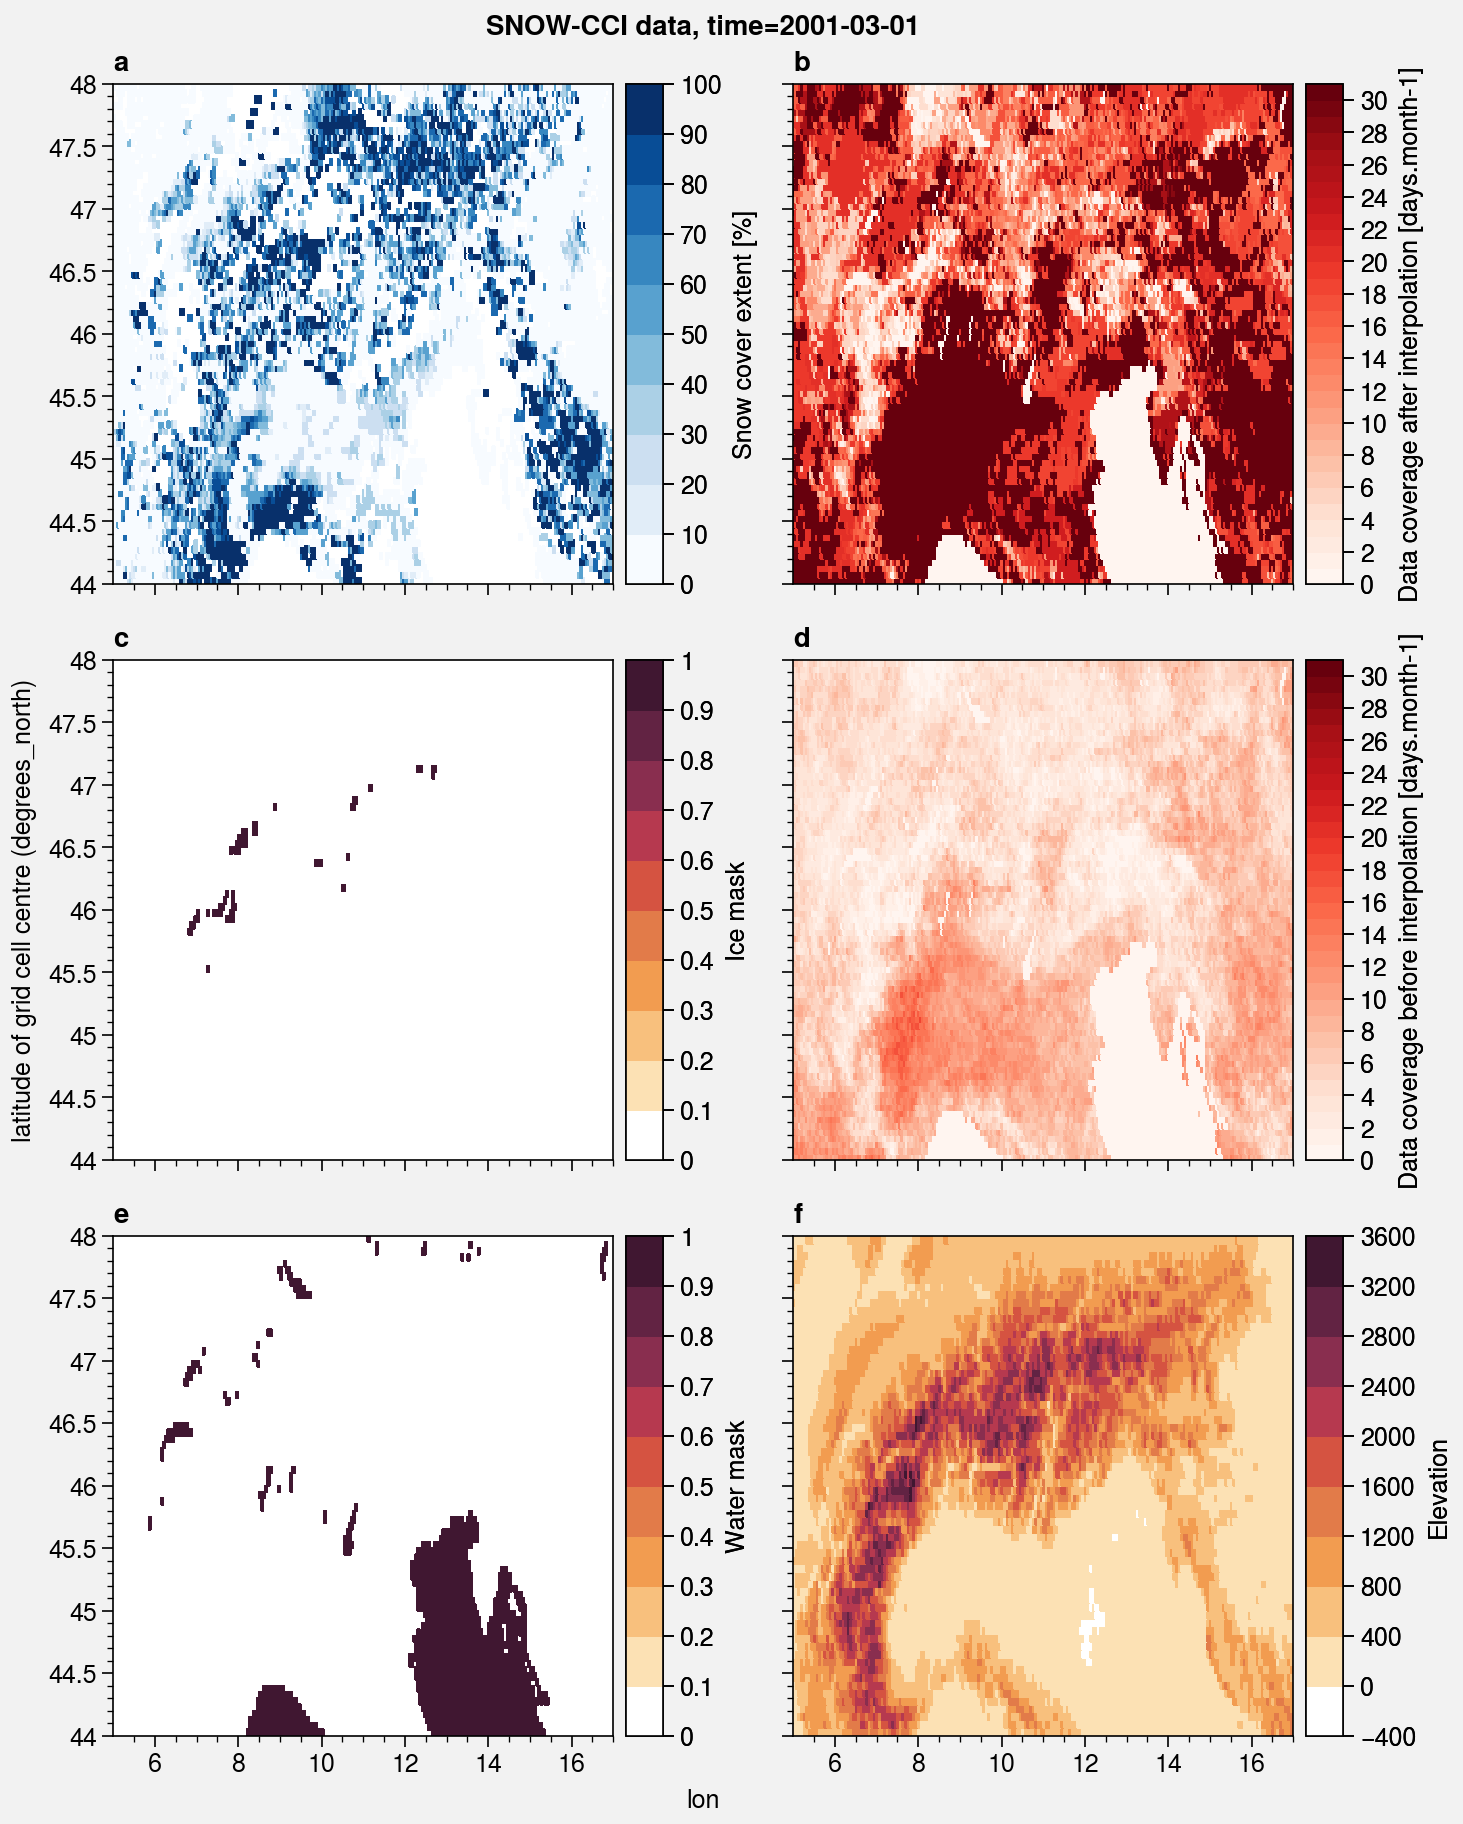

In [26]:
fig,axs = plot.subplots(nrows=3, ncols=2)
axs[0,0].pcolormesh(ds_alps_check.scfg_interp, levels=levels, colorbar='r', cmap=cmap, colorbar_kw={'label': 'Snow cover extent [%]'})
axs[0,1].pcolormesh(ds_alps_check.coverage_interp, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage after interpolation [days.month-1]'})
axs[1,0].pcolormesh(ds_alps_check.mask_ice, colorbar='r',colorbar_kw={'label': 'Ice mask'})
axs[1,1].pcolormesh(ds_alps_check.coverage, levels=levels_coverage, colorbar='r',cmap=cmap_cov, colorbar_kw={'label': 'Data coverage before interpolation [days.month-1]'})
axs[2,0].pcolormesh(ds_alps_check.mask_water, colorbar='r',colorbar_kw={'label': 'Water mask'})
axs[2,1].pcolormesh(elevation, colorbar='r',colorbar_kw={'label': 'Elevation'})
axs.format(
    suptitle='SNOW-CCI data, time='+time_extract,
    abc=True
)

In [41]:
grid_x, grid_y = np.meshgrid(ds_alps.lon, ds_alps.lat)

In [42]:
#np.min(ds_topo.lat), np.max(ds_topo.lat)

In [43]:
ds_topo.lat.shape, ds_topo.lon.shape, ds_topo.elevation.shape, grid_x.shape, grid_y.shape

((64,), (192,), (64, 192), (80, 240), (80, 240))

In [44]:
from scipy.interpolate import interpn
elevation_interp = interpn((ds_topo.lon,ds_topo.lat), ds_topo.elevation, (grid_y, grid_x))

ValueError: There are 192 points and 64 values in dimension 0

In [45]:
# Test with griddata
from scipy.interpolate import griddata
elevation_interp = griddata((ds_topo.lon,ds_topo.lat), ds_topo.elevation, (grid_y, grid_x))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

In [46]:
# Snow cover duration: to be done!
# SCD=